In [0]:
import pandas as pd
pd.options.mode.use_inf_as_na = False
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# MICE was pretty bad at guessing construction year
train = pd.read_csv('PumpItUpTokenizedCleanedMICE_train.csv')
train.status_group = train.status_group.astype(int)
target = train.status_group
train_id = train.id
train = train.drop('id', axis=1)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,40616,0,1390,0,34.938093,-9.856322,0,0,0,0,0,11,5,0,0,109,1.000000,0,0.0,1999.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,41339,1,1399,1,34.698766,-2.147466,1,0,1,1,1,20,2,1,1,280,0.985589,1,1.0,2010.000000,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,1
2,25.0,41330,2,686,2,37.460664,-3.821329,2,0,2,2,2,21,4,2,2,250,1.000000,0,1.0,2009.000000,0,0,0,0,0,2,2,0,0,0,0,2,2,1,1,0,1
3,0.0,41302,3,263,3,38.486161,-11.155298,3,0,3,3,3,90,63,3,3,58,1.000000,0,1.0,1986.000000,1,1,1,0,0,1,1,0,0,2,2,3,3,0,1,0,-1
4,0.0,40737,4,0,4,31.130847,-1.825359,4,0,1,4,4,18,1,4,4,0,1.000000,-1,1.0,1684.993408,0,0,0,2,1,1,1,0,0,3,3,1,1,1,0,0,1


In [4]:
test = pd.read_csv('PumpItUpTokenizedCleanedMICE_test.csv')
test_id = test.id
test = test.drop('id', axis=1)
test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,41309,162,1996,340,35.290799,-4.059696,37400,0,4,10942,2,21,3,37,573,321,1.000000,8,1.000000,2012.0,5,5,3,8,3,1,1,0,0,3,3,1,1,1,3,2
1,0.0,41309,20,1569,5,36.656709,-3.309214,37401,0,2,19287,16,2,2,26,367,300,1.000000,0,1.000000,2000.0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0
2,0.0,41306,-1,1567,-1,34.767863,-5.004344,21518,0,4,7343,18,13,2,32,647,500,1.000000,0,0.761889,2010.0,5,5,3,0,0,1,1,0,0,1,1,1,1,1,3,2
3,0.0,41296,143,267,129,38.058046,-9.418672,37402,0,3,5578,14,80,43,105,1795,250,0.928841,0,1.000000,1987.0,5,5,3,0,0,3,3,0,0,2,2,5,5,0,3,2
4,500.0,41360,1036,1260,1131,35.006123,-10.950412,2984,0,3,2889,9,10,3,97,653,60,0.955065,4,1.000000,2000.0,0,0,0,4,0,6,6,0,0,0,0,0,0,0,0,0


In [5]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 17.22 MB
Memory usage after optimization is: 3.34 MB
Decreased by 80.6%


In [6]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 4.19 MB
Memory usage after optimization is: 0.82 MB
Decreased by 80.4%


In [0]:
train['dist'] = train.longitude ** 2 + train.latitude ** 2
test['dist'] = test.longitude ** 2 + test.latitude ** 2

In [0]:
train['dist2'] = train.gps_height ** 2 + train.dist
test['dist2'] = test.gps_height ** 2 + test.dist

In [0]:
train['wpt_dist_min'] = train.groupby('wpt_name')['dist'].transform('min')
train['wpt_dist_min2'] = train.groupby('wpt_name')['dist2'].transform('min')

test['wpt_dist_min'] = test.groupby('wpt_name')['dist'].transform('min')
test['wpt_dist_min2'] = test.groupby('wpt_name')['dist2'].transform('min')

train['wpt_dist_max'] = train.groupby('wpt_name')['dist'].transform('max')
train['wpt_dist_max2'] = train.groupby('wpt_name')['dist2'].transform('max')

test['wpt_dist_max'] = test.groupby('wpt_name')['dist'].transform('max')
test['wpt_dist_max2'] = test.groupby('wpt_name')['dist2'].transform('max')

In [0]:
train['construct_record_min'] = train.groupby('construction_year')['date_recorded'].transform('min')
test['construct_record_min'] = test.groupby('construction_year')['date_recorded'].transform('min')

train['construct_record_max'] = train.groupby('construction_year')['date_recorded'].transform('max')
test['construct_record_max'] = test.groupby('construction_year')['date_recorded'].transform('max')

train['construct_record'] = (train.date_recorded - train.construction_year)
train['construct_record_2'] = (train.date_recorded - train.construction_year) / train.construction_year

test['construct_record'] = (test.date_recorded - test.construction_year)
test['construct_record_2'] = (test.date_recorded - test.construction_year) / test.construction_year

Text(0.5, 1.0, 'Variable Correlations')

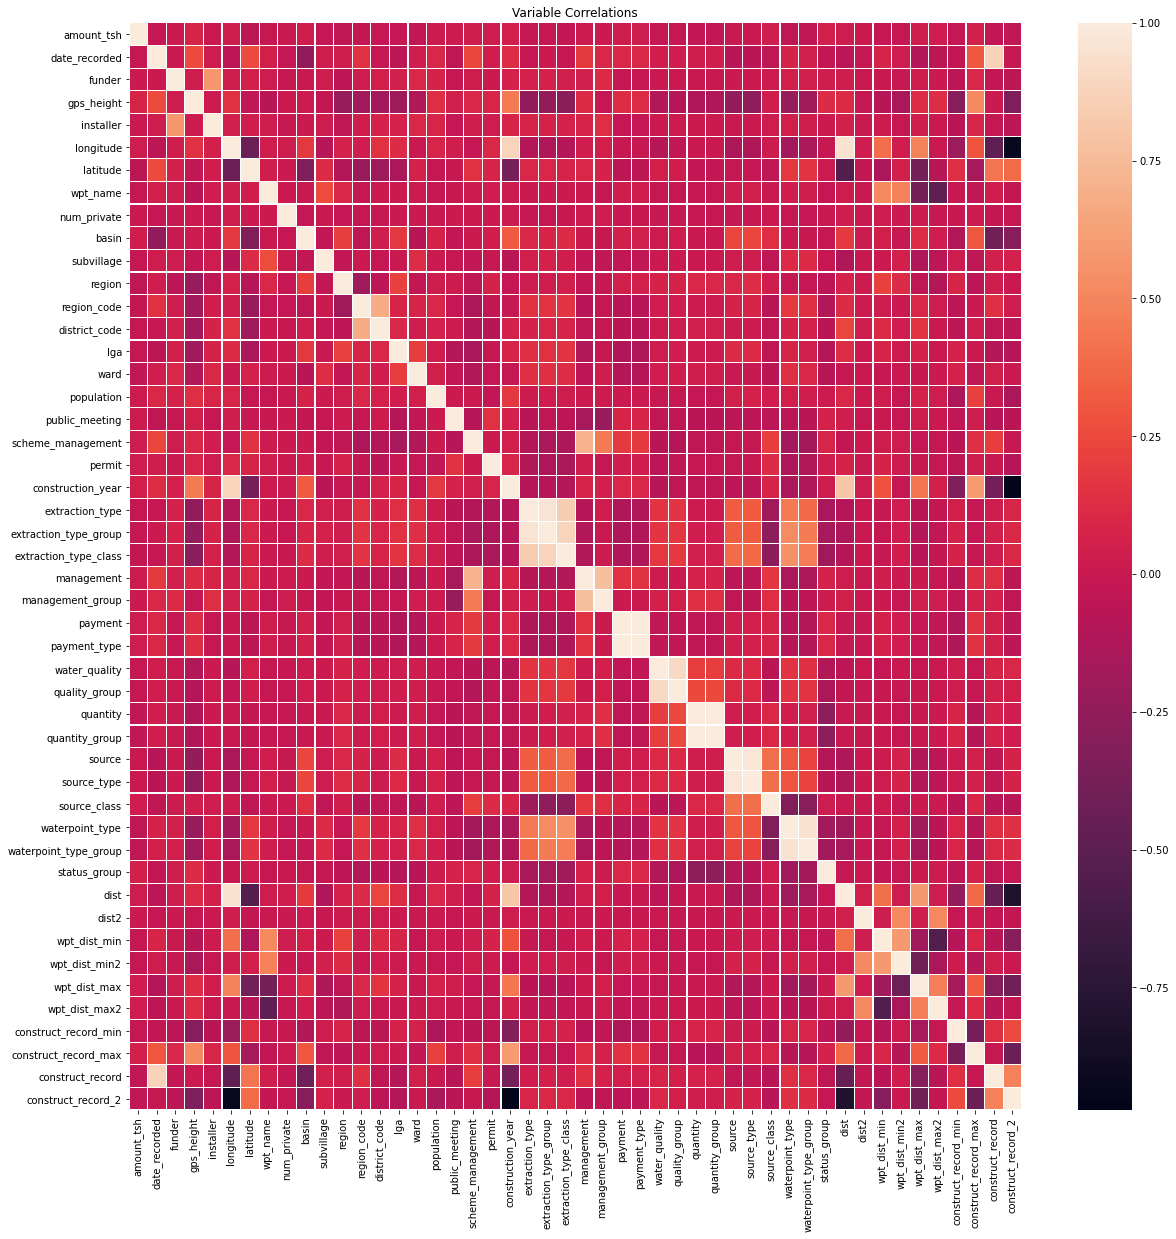

In [11]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(20,20))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [12]:
from sklearn.decomposition import PCA

def principal_component_analyze(df):

    extraction_type = df.extraction_type
    extraction_type_group = df.extraction_type_group
    extraction_type_class = df.extraction_type_class
    
    extraction = pd.DataFrame(data=list(zip(extraction_type, extraction_type_group, extraction_type_class)),
                  columns = ['extraction_type', 'extraction_type_group', 'extraction_type_class'])

    pca_extraction = PCA(n_components=1)
    extractpca = pca_extraction.fit_transform(extraction)
    df['extraction'] = extractpca
    print("Extraction EVR", pca_extraction.explained_variance_ratio_)
    
    
    management = df.management
    management_group = df.management_group
    
    manage = pd.DataFrame(data=list(zip(management, management_group)),
                  columns = ['management', 'management_group'])

    pca_manage = PCA(n_components=1)
    managementpca = pca_manage.fit_transform(manage)
    df['manage'] = managementpca
    print("Management EVR", pca_manage.explained_variance_ratio_)
    
    
    payment = df.payment
    payment_type = df.payment_type
    
    pay = pd.DataFrame(data=list(zip(payment, payment_type)),
                  columns = ['payment', 'payment_type'])

    pca_pay = PCA(n_components=1)
    paypca = pca_pay.fit_transform(pay)
    df['pay'] = paypca
    print("Payment EVR", pca_pay.explained_variance_ratio_)
    
    
    water_quality = df.water_quality
    quality_group = df.quality_group
    
    quality = pd.DataFrame(data=list(zip(water_quality, quality_group)),
                  columns = ['water_quality', 'quality_group'])

    pca_qual = PCA(n_components=1)
    qualpca = pca_qual.fit_transform(quality)
    df['qual'] = qualpca
    print("Quality EVR", pca_qual.explained_variance_ratio_)
    
    
    quantity = df.quantity
    quantity_group = df.quantity_group
    
    quant = pd.DataFrame(data=list(zip(quantity, quantity_group)),
                  columns = ['quantity', 'quantity_group'])

    pca_quant = PCA(n_components=1)
    quantpca = pca_quant.fit_transform(quant)
    df['manage'] = quantpca
    print("Quantity EVR", pca_quant.explained_variance_ratio_)
    
    
    source = df.source
    source_type = df.source_type
    
    ss = pd.DataFrame(data=list(zip(source, source_type)),
                  columns = ['source', 'source_type'])

    pca_ss = PCA(n_components=1)
    sspca = pca_ss.fit_transform(ss)
    df['ss'] = sspca
    print("Source EVR", pca_ss.explained_variance_ratio_)
    
    
    waterpoint_type = df.waterpoint_type
    waterpoint_type_group = df.waterpoint_type_group
    
    waterpoint = pd.DataFrame(data=list(zip(waterpoint_type, waterpoint_type_group)),
                  columns = ['waterpoint_type', 'waterpoint_type_group'])

    pca_waterpoint = PCA(n_components=1)
    waterpointpca = pca_waterpoint.fit_transform(waterpoint)
    df['waterpoint'] = waterpointpca
    print("Waterpoint EVR", pca_waterpoint.explained_variance_ratio_)
    
    
    district_code = df.district_code
    region_code = df.region_code
    
    code = pd.DataFrame(data=list(zip(district_code, region_code)),
                  columns = ['district_code', 'region_code'])

    pca_code = PCA(n_components=1)
    codepca = pca_code.fit_transform(code)
    df['code'] = codepca
    print("Code EVR", pca_code.explained_variance_ratio_)
    
    
    #df = df.drop(['extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'district_code', 'region_code', 
                 #'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group'], axis=1)
    
    return df
  
train = principal_component_analyze(train)
test = principal_component_analyze(test)

Extraction EVR [0.95678236]
Management EVR [0.96039072]
Payment EVR [1.]
Quality EVR [0.95462718]
Quantity EVR [1.]
Source EVR [0.98684648]
Waterpoint EVR [0.98064153]
Code EVR [0.89271392]
Extraction EVR [0.95597614]
Management EVR [0.9606198]
Payment EVR [1.]
Quality EVR [0.95550984]
Quantity EVR [1.]
Source EVR [0.98588773]
Waterpoint EVR [0.98080023]
Code EVR [0.89214725]


In [0]:
# We can completely remove the features of which the PCA is 1 because this means that they are the exact same values for every data point
# The other pairs/groups of features are still very similar but it might be useful to keep them anyways

train.drop("payment_type", axis=1, inplace=True)
test.drop("payment_type", axis=1, inplace=True)

train.drop("quantity_group", axis=1, inplace=True)
test.drop("quantity_group", axis=1, inplace=True)

In [14]:
!pip3 install pygeohash
import pygeohash as gh

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6163 sha256=ba0695383f48477d1373062f286e1279ff1e1266373e87871e2f0adc4f991b0e
  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash


In [0]:
train['geohash'] = train.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)
test['geohash'] = test.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)

# factorize
geohash_factorized, mapping = train.geohash.factorize()
train.geohash = geohash_factorized

factorization = [i for i in range(0, len(mapping))]
  
factorization_map = dict(zip(mapping, factorization))
print(factorization_map)

test.geohash = test.geohash.map(factorization_map)

In [0]:
train['geohash2'] = train.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)
test['geohash2'] = test.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)

# factorize
geohash2_factorized, mapping2 = train.geohash2.factorize()
train.geohash2 = geohash2_factorized

factorization2 = [i for i in range(0, len(mapping2))]
  
factorization_map2 = dict(zip(mapping2, factorization2))
print(factorization_map2)

test.geohash2 = test.geohash2.map(factorization_map2)

In [0]:
train['geohash3'] = train.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)
test['geohash3'] = test.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)

# factorize
geohash3_factorized, mapping3 = train.geohash3.factorize()
train.geohash3 = geohash3_factorized

factorization3 = [i for i in range(0, len(mapping3))]
  
factorization_map3 = dict(zip(mapping3, factorization3))
print(factorization_map3)

test.geohash3 = test.geohash3.map(factorization_map3)

In [0]:
del geohash3_factorized, mapping3, factorization3, factorization_map3, geohash2_factorized, mapping2, factorization2, factorization_map2, geohash_factorized, mapping, factorization, factorization_map

In [19]:
test.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dist                     0
dist2                    0
w

In [0]:
test.geohash3 = test.geohash3.fillna(-1)

In [21]:
test.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dist                     0
dist2                    0
w

In [22]:
len(train.geohash.unique())

6

In [23]:
len(train.geohash2.unique())

56

In [24]:
len(train.geohash3.unique())

946

In [25]:
len(test.geohash.unique())

6

In [26]:
len(test.geohash2.unique())

56

In [27]:
len(test.geohash3.unique())

857

In [32]:
import folium
from folium.plugins import HeatMap

# Train locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in train.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [33]:
# Test locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in test.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [30]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 10.14 MB
Memory usage after optimization is: 5.61 MB
Decreased by 44.7%


In [31]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 2.52 MB
Memory usage after optimization is: 1.39 MB
Decreased by 44.9%


Text(0.5, 1.0, 'Variable Correlations')

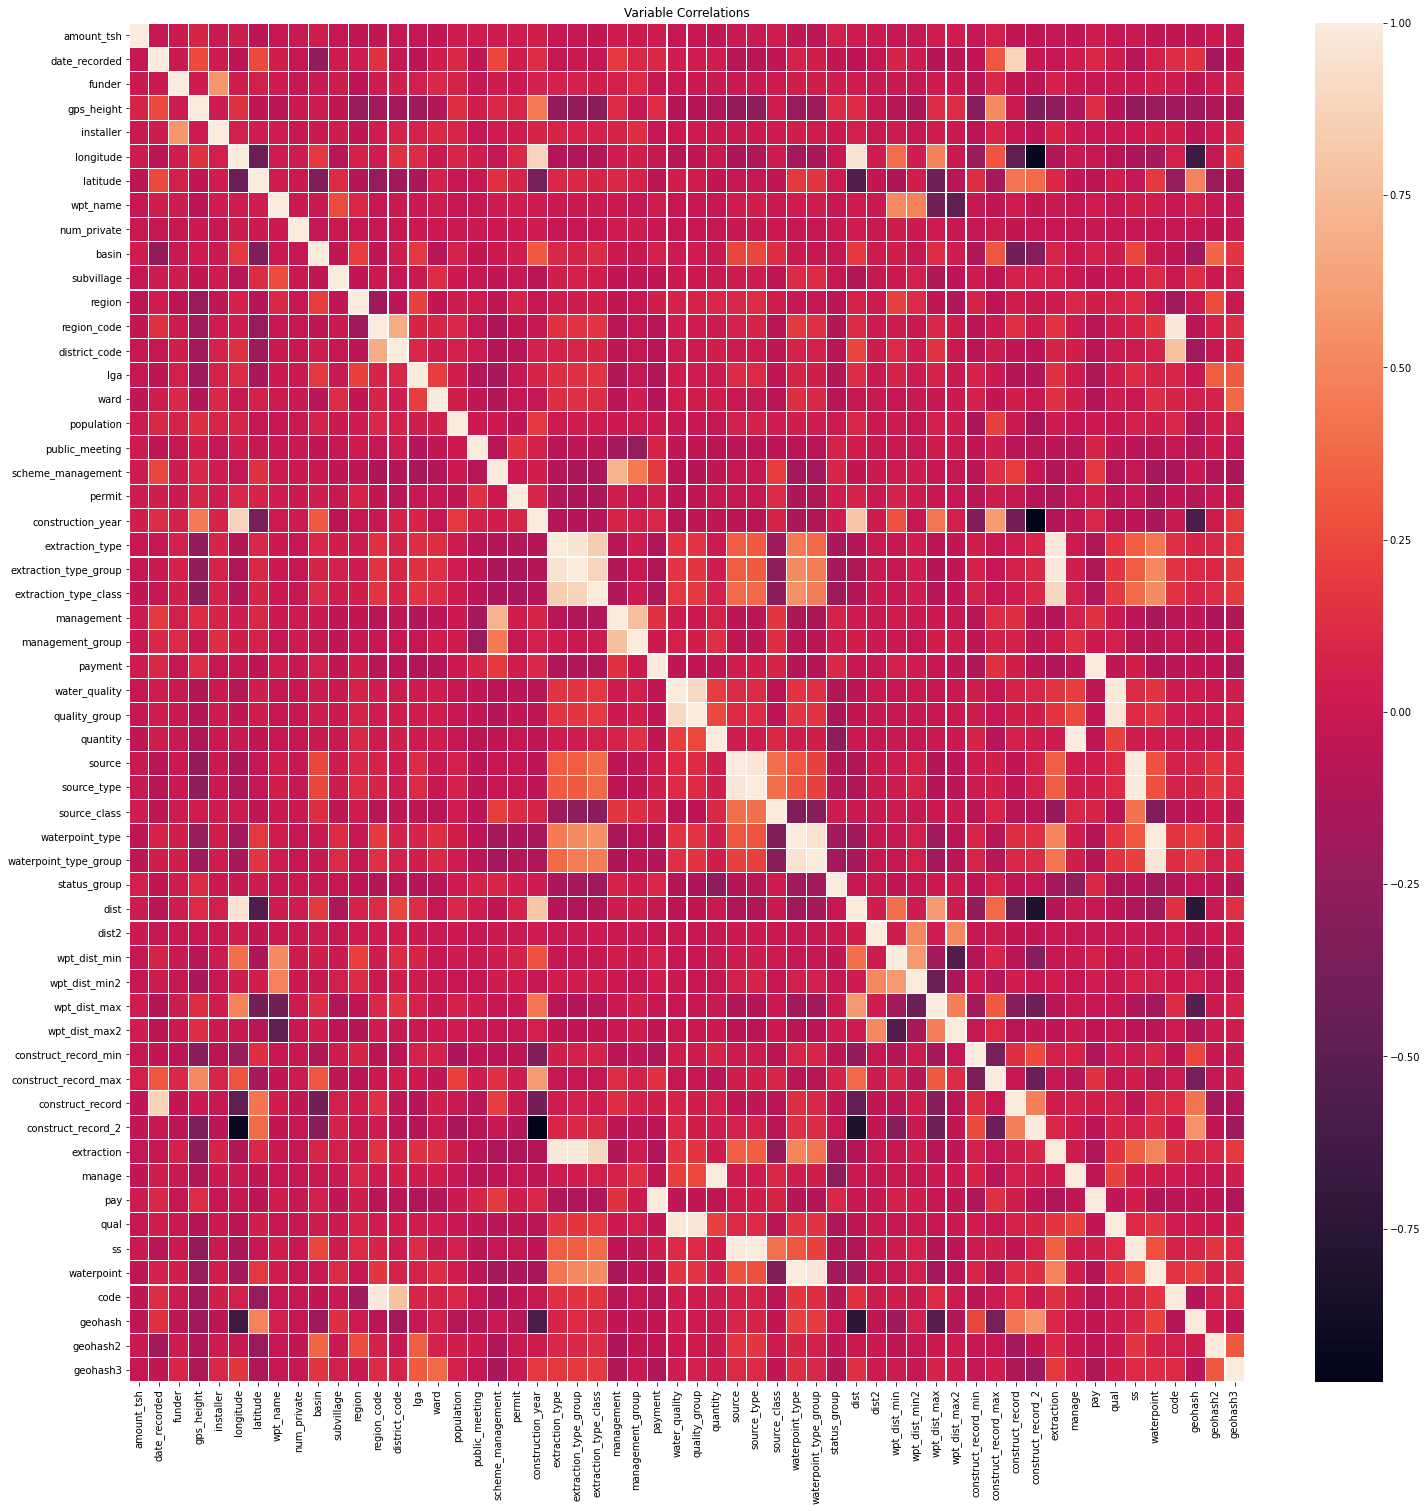

In [0]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(25,25))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [0]:
status_groups = train.status_group
train = train.drop('status_group', axis=1)

In [0]:
submit = pd.DataFrame({
        "id": test_id.values
        })

In [0]:
!pip3 -q install catboost
from catboost import CatBoostClassifier, Pool

     |████████████████████████████████| 64.4MB 42kB/s 


In [0]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=100, random_state=42, shuffle=True)

In [0]:
clf = CatBoostClassifier(iterations=10000, custom_metric=['AUC','Accuracy'], loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain', 
                         max_depth=8, random_state=42, od_type="Iter")

In [0]:
for idx, (train_index, valid_index) in enumerate(kfold.split(train)):
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    print("Valid samples:", len(X_valid))
    clf.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=100, use_best_model=True, plot=True)
    y_test_pred = clf.predict(test) 
    submit[str('status_group_' + str(idx+1))] = y_test_pred.ravel()
    print(clf.best_score_)
    clf.save_model('clf' + str(idx+1) + '.hdf5')
    #clf.plot_tree(tree_idx=123, pool=cat_train)
    #feature_stuff = pd.DataFrame(zip(clf.feature_names_, clf.feature_importances_))
    #ax, f = plt.subplots(figsize=(25, 15))
    #sns.barplot(x=1, y=0, data=feature_stuff, label="Feature_Importances_" + str(idx+1))

In [0]:
submit.head(25)

In [0]:
import statistics

status = []
for i in range(0, len(submit)):
  listy = [] 
  for j in submit.columns[1:]: # removes id column
    listy.append(submit[j][i]) # appends each column's i index to list
  try:
    mode = statistics.mode(listy)
    status.append(mode)
  except:
    print('no mode')
    print(listy)
    avg = sum(listy)/len(listy)
    if avg<-0.225: # change threshold
      average = -1
    elif avg>0.225: # change threshold
      average =  1
    else:
      average = 0
    print(average)
    print("\n")
    status.append(average)

no mode
[-1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1]
0


no mode
[1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, 1, -1]
0


no mode
[-1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 

In [0]:
submission = pd.DataFrame({
    "id": test_id.values,
    "status_group": status
})
submission.status_group = submission.status_group.astype(int)
del status, listy, mode

In [0]:
submission.head(25)

,id,status_group
0,50785,-1
1,51630,1
2,17168,1
3,45559,-1
4,49871,1
5,52449,1
6,24806,-1
7,28965,-1
8,36301,-1
9,54122,1


Text(0.5, 1.0, 'TRAIN:')

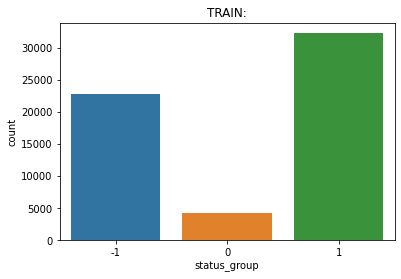

In [0]:
sns.countplot(status_groups)
plt.title('TRAIN:')

Text(0.5, 1.0, 'PREDICTIONS:')

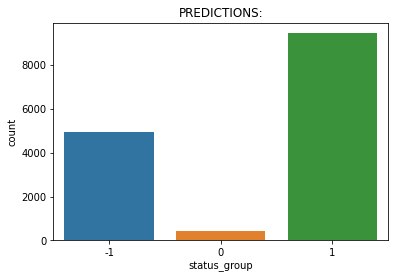

In [0]:
sns.countplot(submission.status_group)
plt.title('PREDICTIONS:')

In [0]:
submission.status_group = submission.status_group.map({1: "functional", -1: "non functional", 0: "functional needs repair"})
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('PUMPITUP_SUBMISSION_9.csv', index=False)
from google.colab import files
files.download('PUMPITUP_SUBMISSION_9.csv')

In [0]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')